In [5]:
import os
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from statistics import mean, stdev
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

## Ukuran plot besar
# sns.reset_defaults()
# Ukuran plot kecil
sns.reset_orig()

sns.set_style('whitegrid', {'grid.linestyle': '--'})



C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [6]:
np.random.seed(500)

## Persiapan Input
**Corpus** memuat teks yang sudah dibersihkan (di tahap prapengolahan).
**LabelInset** memuat label teks dengan leksikon `InSet`.
**LabelSenti** memuat label teks dengan leksikon `sentiStrength`

In [7]:
# Pastikan untuk mengganti path dengan absolute path direktorimu jika baris berikut dijalankan ulang, atau restart kernel.
os.chdir('output')
base = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-dup.txt'
lb_inset = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-lb-inset.txt'
lb_senti = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-lb-senti.txt'

Corpus = pd.read_csv(base, encoding='latin-1', header=None, sep='\t', names=['text'], dtype=str)
LabelInset = pd.read_csv(lb_inset, encoding='latin-1', header=None, names=['label'], dtype=str)
LabelSenti = pd.read_csv(lb_senti, encoding='latin-1', header=None, names=['label'], dtype=str)

In [8]:
# Jumlah positif dan negatif dari setiap jenis pelabelan
neg1, pos1 = (LabelInset['label'][LabelInset['label']=='neg']).count(), (LabelInset['label'][LabelInset['label']=='pos']).count()
neg2, pos2 = (LabelSenti['label'][LabelSenti['label']=='neg']).count(), (LabelSenti['label'][LabelSenti['label']=='pos']).count()
print('neg:', neg1, '(', '{0:.2f}'.format(neg1/(neg1+pos1)*100), '%)','\t', 'pos:', pos1, '(', '{0:.2f}'.format(pos1/(neg1+pos1)*100),'%)',' | inset')
print('neg:', neg2, '(', '{0:.2f}'.format(neg2/(neg2+pos2)*100), '%)','\t', 'pos:', pos2, '(', '{0:.2f}'.format(pos2/(neg2+pos2)*100),'%)',' | senti')

neg: 4981 ( 40.68 %) 	 pos: 7262 ( 59.32 %)  | inset
neg: 5053 ( 41.27 %) 	 pos: 7190 ( 58.73 %)  | senti


### **\*Perhatian:** pilih salah satu jenis label sebagai *baseline* untuk proses selanjutnya

In [9]:
## Menggunakan pelabelan dari InSet
LL = LabelInset

## Menggunakan pelabelan dari sentiwords_id
# LL = LabelSenti

In [10]:
print(Corpus[:3], '\n\n', LL[:3])

                                           text
0                 ikn indonesia maju ikn negeri
1  gubernur pindah ibukota dorong turun senjang
2          indonesia negara nusantara ibukotaku 

   label
0   neg
1   neg
2   neg


## Tokenisasi Teks

In [11]:
# Step - a : Menghapus baris kosong, jika ada.
Corpus['text'].dropna(inplace=True)
# # Step - b : Mengganti semua teks ke karakter kecil karena 'oke' dan 'OKE' diinterpretasikan berbeda
# Corpus['text'] = [entry.lower() for entry in Corpus['text']] # we've done this in '[1] text cleaning.ipynb'
# Step - c : Tokenisasi : Setiap kalimat di dalam korpus akan dipecah menjadi daftar kata/string
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

for index,entry in enumerate(Corpus['text']):
    # Mendeklarasikan list kosong untuk menyimpan daftar kata yang sesuai dengan aturan yang dibuat
    Final_words = []
    for word in entry:
        # Kondisi di bawah adalah untuk mengecek/mempertimbangkan alfabet saja
        if word.isalpha():
            word_Final = word
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = str(Final_words)

<blockquote>Ref: <i>https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34</i></blockquote>

In [12]:
print(Corpus[:3])

                                                text  \
0                [ikn, indonesia, maju, ikn, negeri]   
1  [gubernur, pindah, ibukota, dorong, turun, sen...   
2          [indonesia, negara, nusantara, ibukotaku]   

                                          text_final  
0      ['ikn', 'indonesia', 'maju', 'ikn', 'negeri']  
1  ['gubernur', 'pindah', 'ibukota', 'dorong', 't...  
2  ['indonesia', 'negara', 'nusantara', 'ibukotaku']  


## Split Data

In [13]:
# Membagi set data latih dan data uji dengan rasio 70:30
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],
                                                                    LL['label'],test_size=0.3, random_state=42)

In [14]:
print(Train_X.size, Train_X.size/(Test_X.size+Train_X.size),'%','\n',
      Test_X.size, Test_X.size/(Test_X.size+Train_X.size),'%')

8570 0.6999918320673038 % 
 3673 0.30000816793269625 %


In [15]:
# Encoding label menjadi nilai antara 0 and kelas_n-1
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)


In [16]:
# print('TRAIN_X'+'\n', Train_X, '\n')
# print('TEST_X'+'\n', Test_X, '\n')
# print('TRAIN_Y'+'\n', Train_Y, '\n')
# print('TEST_Y'+'\n', Test_Y, '\n')
# # with np.printoptions():
# #     print(Test_X[:17])

# EKSTRAKSI FITUR: 

## *BoW*

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Corpus['text_final'])

In [18]:
# Transform Train_X dan Test_X ke vektor BoW
Train_X_BoW = vectorizer.transform(Train_X)
Test_X_BoW = vectorizer.transform(Test_X)

## *TF-IDF*

In [19]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(Corpus['text_final'])

X = Tfidf_vect.fit_transform(Corpus['text_final'])

#### opsi lain yang bisa dipertimbangkan:

<code> Tfidf_vect = TfidfVectorizer(max_features=None).fit(Corpus['text_final']) <code>
<code> Tfidf_vect = TfidfVectorizer(max_features=5000).fit(Corpus['text_final']) <code>
<code> Tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, \
                    use_idf=True).fit(Corpus['text_final']) <code>

In [20]:
# Transform Train_X dan Test_X ke vektor TF-IDF
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

##  Hyperparameter Optimization using GridSearch CV

In [62]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto/scale
svc=SVC() 

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 100, 1000], 'kernel':['linear']},
               {'C':[1, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


#Train data BoW
grid_search.fit(Train_X_BoW, Train_Y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [64]:
grid_search_Tfidf = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
#Train data TF-IDF
grid_search_Tfidf.fit(Train_X_Tfidf, Train_Y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [65]:
### BoW ###
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---BoW---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search.best_estimator_))

### TF-IDF ###
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---TF-IDF---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search_Tfidf.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search_Tfidf.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search_Tfidf.best_estimator_))



---BoW---

GridSearch CV best score : 0.9273

Parameters that give the best results : {'C': 1000, 'kernel': 'linear'}

Estimator that was chosen by the search : SVC(C=1000, kernel='linear')


---TF-IDF---

GridSearch CV best score : 0.9313

Parameters that give the best results : {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Estimator that was chosen by the search : SVC(C=100, gamma=0.1)


In [67]:
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(Test_X_BoW, Test_Y)))
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search_Tfidf.score(Test_X_Tfidf, Test_Y)))

GridSearch CV score on test set: 0.9366
GridSearch CV score on test set: 0.9426


## Definisikan Classifier 

mendefinisikan clisifier berdasarkan best score pada masing-masing kombinasi fitur ekstraksi dan leksikon

In [21]:
# Menggunakan SVM dengan kernel hasil Grid Search CV sebagai classifier
linear1000 = svm.SVC(kernel='linear', C=1000.0, random_state=42)#karnel linier dengan C=1000.0
rbf100=SVC(C=100.0, gamma=0.1, random_state=42) #karnel RBF dengan C=100.0

## KLASIFIKASI dengan SVM menggunakan Best Parameter hasil Grid Search CV

### BoW

In [22]:
# SVM dengan Karnel Linier C=1000.0
## fitting data latih pada classifier
linear1000.fit(Train_X_BoW,Train_Y)

## memprediksi label pada set data uji
predictions_SVM_BoW_Linier1000 = linear1000.predict(Test_X_BoW)

## Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Bow_linear1000 = accuracy_score(Test_Y, predictions_SVM_BoW_Linier1000)*100
print('Model accuracy score with linear kernel and C=1000.0  -> ', accuracy_Bow_linear1000)

Model accuracy score with linear kernel and C=1000.0  ->  93.65641165260006


### TF-IDF

In [23]:
#### SVM dengan Karnel RBF dan C=100.0 Gamma =0.1####
# fitting data latih pada classifier
rbf100.fit(Train_X_Tfidf,Train_Y)

# memprediksi label pada set data uji
predictions_SVM_Tfidf_RBF100 = rbf100.predict(Test_X_Tfidf)

# Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Tfidf_rbf100 = accuracy_score(Test_Y, predictions_SVM_Tfidf_RBF100)*100
print('Model accuracy score with rbf kernel and C=100.0 -> ', accuracy_Tfidf_rbf100)

Model accuracy score with rbf kernel and C=100.0 ->  94.2553770759597


In [24]:
# # Membandingkan Nilai Leksikon dengan Nilai Prediksi
df = pd.DataFrame({'Lexicon Values':Test_Y, 'Predicted Values':predictions_SVM_Tfidf_RBF100})
df[:10]

,Lexicon Values,Predicted Values
0,0,1
1,0,0
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,0,0


## **Gambaran Data:**

In [25]:
# Gambaran rasio data latih dan data uji dari teks awal dan dari vektor ekstraksi fitur.
print('X:', Corpus['text'].size,
      '\nTrain\tTest\t\t%train\t%test\n',
      
      Train_X.size, '\t', Test_X.size, '\tX\t', '{:.2f}'.format(Train_X.size/(Test_X.size+Train_X.size)*100), '\t', '{:.2f}'.format(Test_X.size/(Test_X.size+Train_X.size)*100), '\n',
      Train_X_BoW.size, '\t', Test_X_BoW.size, '\tBoWs\t', '{:.2f}'.format(Train_X_BoW.size/(Test_X_BoW.size+Train_X_BoW.size)*100), '\t', '{:.2f}'.format(Test_X_BoW.size/(Test_X_BoW.size+Train_X_BoW.size)*100), '\n',
      Train_X_Tfidf.size, '\t', Test_X_Tfidf.size, '\tTF-IDF\t', '{:.2f}'.format(Train_X_Tfidf.size/(Test_X_Tfidf.size+Train_X_Tfidf.size)*100), '\t', '{:.2f}'.format(Test_X_Tfidf.size/(Test_X_Tfidf.size+Train_X_Tfidf.size)*100))

# Gambaran jumlah kelas negatif dan positif dari data uji dengan label aktual, label leksikon, and label prediksi;
# Label aktual dan label leksikon disimbolkan sebagai 'Test_Y_Actual' dan 'Test_Y';
# Jika kamu memakai label aktual sebagai baseline, maka label leksikon di sini adalah label aktual itu sendiri.
print('\nneg\tpos\t\tsum\n',
      (Test_Y==0).sum(), '\t', (Test_Y==1).sum(), '\t', Test_Y.size, '\tTest_Y\n',
      (predictions_SVM_BoW_Linier1000==0).sum(),   '\t', (predictions_SVM_BoW_Linier1000==1).sum(),   '\t', predictions_SVM_BoW_Linier1000.size,   '\tP_BoWs_Linier(C=1000.0)\n',
      (predictions_SVM_Tfidf_RBF100==0).sum(), '\t', (predictions_SVM_Tfidf_RBF100==1).sum(), '\t', predictions_SVM_Tfidf_RBF100.size, '\tP_Tfidf_rbf(C=100.0)\n',
     )

X: 12243 
Train	Test		%train	%test
 8570 	 3673 	X	 70.00 	 30.00 
 73184 	 31932 	BoWs	 69.62 	 30.38 
 73184 	 31932 	TF-IDF	 69.62 	 30.38

neg	pos		sum
 1495 	 2178 	 3673 	Test_Y
 1470 	 2203 	 3673 	P_BoWs_Linier(C=1000.0)
 1504 	 2169 	 3673 	P_Tfidf_rbf(C=100.0)



### Comments

Hasil model ini mendapatkan akurasi maksimum dari fitur ekstraksi `TF-IDF` dan kernel `RBF C=100.0` dan `gamma =0,1`dengan akurasi sebesar `94,26%`, dan di posisi kedua dengan nilai akurasi `93,66%` dari kombinasi `BoW` dengan karnel `linier C=100.0`. Berdasarkan analisis di atas dapat disimpulkan bahwa akurasi model klasifikasi yang digunakan sangat baik. Model kami melakukan pekerjaan yang sangat baik dalam hal memprediksi label kelas.

Namun, ini tidak sepenuhnya benar karena data yang digunakan terdapat ketidakseimbangan antara kelas positif dan kelas negatif yang menyebabkan adanya missklasifikasi pada data yang menghasilkan label data yang cenderung lebih mayor pada data latih. 

Pada penelitian terdahulu yang di lakukan oleh (Ganganwar, 2012) menyatakan bahwa kumpulan data yang tidak seimbang dapat menyebabkan miss-klasifikasi pada data. Hal ini dikarenakan perbedaan jumlah dataset antara kelas mayor dan minor yang bisa membuat kelas mayor memiliki kinerja yang lebih baik daripada kelas minor.


Jadi, kita harus mengeksplorasi metrik alternatif yang memberikan panduan yang lebih baik dalam memilih model. Secara khusus, saya ingin mengetahui distribusi nilai yang mendasari dan jenis kesalahan yang dibuat oleh classifer yang digunakan.


Salah satu metrik untuk menganalisis kinerja model dalam masalah kelas tidak seimbang adalah `Confusion matrix`.

# EVALUASI / VALIDASI 

## Confusion Matrix

In [26]:
# Print the Confusion Matrix and slice it into four pieces
y_true =Test_Y

## BoW ~ Linier C=100 ##
print('\n### Confusion Matrix - BoW ###')
y_pred = predictions_SVM_Tfidf_RBF100
cm = confusion_matrix(y_true, y_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])


### Confusion Matrix - BoW ###
Confusion matrix

 [[1394  101]
 [ 110 2068]]

True Positives(TP) =  1394

True Negatives(TN) =  2068

False Positives(FP) =  101

False Negatives(FN) =  110


Confusion matrix menunjukkan `1366 + 2074 = 3440 prediksi yang benar` dan `104 + 129 = 233 prediksi yang salah`.


Dalam hal ini, kami memiliki

- `True Positives` (Positif Aktual:1 dan Prediksi Positif:1) - 1394


- `True Negatives` (Negatif Aktual:0 dan Prediksi Negatif:0) - 2068


- `False Positives` (Actual Negative:0 tetapi Predict Positive:1) - 101 `(Kesalahan tipe I)`


- `False Negatives` (Positif Aktual:1 tetapi Prediksi Negatif:0) - 110 `(Kesalahan Tipe II)`

<AxesSubplot: >

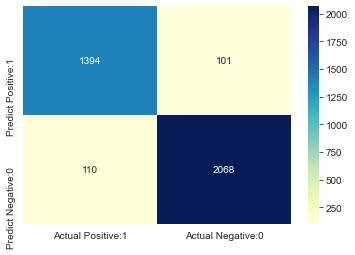

In [27]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Classification metrices

### Classification Report:
Classification report adalah cara lain untuk mengevaluasi kinerja model klasifikasi. Ini menampilkan `presisi`, `recall`, `f1` dan `support scores` untuk model.

### Classification Report: SVM Karnel Linier

In [31]:
# Membuat classification report

## TF-IDF ##
print('TF-IDF - linear C=1.0\n',
      classification_report(Test_Y, predictions_SVM_Tfidf_RBF100))


TF-IDF - linear C=1.0
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1495
           1       0.95      0.95      0.95      2178

    accuracy                           0.94      3673
   macro avg       0.94      0.94      0.94      3673
weighted avg       0.94      0.94      0.94      3673



### Classification accuracy

In [32]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [33]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9426


### Classification error

In [34]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0574


## Validasi dengan k-Fold Cross Validation
Ubah nilai `n_splits` sesuai dengan kebutuhan. Sebagai contoh, 5 splits berarti bahwa data (X dan y oversample) dibagi menjadi *4 porsi* untuk set latih baru dan *1 porsi* untuk set uji baru. Jika `shuffle` bernilai True, maka validasi silang dilakukan dengan kombinasi data yang berbeda di setiap iterasi. Kemudian validasi silang dilakukan dalam 5 iterasi.

### Stratified k-Fold Cross Validation with shuffle split with  rbf kernel

In [35]:
kfold=KFold(n_splits=5, shuffle=True, random_state=0)
rbf100_scores = cross_val_score(rbf100, Train_X_BoW, Train_Y, cv=kfold)

# print cross-validation scores with rbf kernel
print('/n/nStratified cross-validation scores with linear kernel:\n{}'.format(rbf100_scores))

/n/nStratified cross-validation scores with linear kernel:
[0.91656943 0.91190198 0.91423571 0.91656943 0.91540257]


In [37]:
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(rbf100_scores)*100, '%')
print('\nMinimum Accuracy:',
      min(rbf100_scores)*100, '%')
print('\nOverall Accuracy:',
      mean(rbf100_scores)*100, '%')
print('\nStandard Deviation is:', stdev(rbf100_scores))


Maximum Accuracy That can be obtained from this model is: 91.65694282380397 %

Minimum Accuracy: 91.1901983663944 %

Overall Accuracy: 91.49358226371062 %

Standard Deviation is: 0.0019525321506045897


https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

In [38]:
# Simpan nilai presisi, recall, dan f1-score ke file
def cr_oversampled(featExt, precision, recall, f1):
    output = 'svm_cr_inset_'+str(featExt)+'_kfold.txt'
    with open(output, 'a') as f:
        f.write(str(precision)+'\t'+str(recall)+'\t'+str(f1)+'\n')

In [39]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

y = LL
y = Encoder.fit_transform(y)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
print('BoW - Karnel Linier(C=1000.0)')
featExt = 'bow'

X = vectorizer.fit_transform(Corpus['text_final'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linear1000.fit(X_train, y_train)
    y_pred = linear1000.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #print to file
    cr_oversampled(featExt, precision, recall, f1)

    print(f'# Fold {fold}:')
    print(classification_report(y_test, y_pred), "\n")
    
#     print(f'accuracy: {accuracy}')
#     print(f'precision: {precision}')
#     print(f'recall: {recall}')
#     print(f'f-score: {f1}')

BoW - Karnel Linier(C=1000.0)
# Fold 1:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       976
           1       0.95      0.96      0.96      1473

    accuracy                           0.95      2449
   macro avg       0.94      0.94      0.94      2449
weighted avg       0.95      0.95      0.95      2449
 

# Fold 2:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1032
           1       0.93      0.96      0.95      1417

    accuracy                           0.94      2449
   macro avg       0.94      0.93      0.93      2449
weighted avg       0.94      0.94      0.94      2449
 

# Fold 3:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1005
           1       0.94      0.96      0.95      1444

    accuracy                           0.94      2449
   macro avg       0.94      0.94      0.94      2449
weighted a

In [44]:
print('TF-IDF - Karnel RBF(C=100.0)')
featExt = 'tfidf'

X = Tfidf_vect.fit_transform(Corpus['text_final'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    rbf100.fit(X_train, y_train)
    y_pred = rbf100.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #print to file
    cr_oversampled(featExt, precision, recall, f1)

    print(f'# Fold {fold}:')
    print(classification_report(y_test, y_pred), "\n")

TF-IDF - Karnel RBF(C=100.0)
# Fold 1:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       976
           1       0.95      0.95      0.95      1473

    accuracy                           0.94      2449
   macro avg       0.94      0.94      0.94      2449
weighted avg       0.94      0.94      0.94      2449
 

# Fold 2:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1032
           1       0.95      0.94      0.95      1417

    accuracy                           0.94      2449
   macro avg       0.94      0.94      0.94      2449
weighted avg       0.94      0.94      0.94      2449
 

# Fold 3:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1005
           1       0.95      0.96      0.96      1444

    accuracy                           0.95      2449
   macro avg       0.95      0.95      0.95      2449
weighted av

In [45]:
# data00 = pd.read_csv('svm_cr_ov_lb1_tp_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])
data01 = pd.read_csv('svm_cr_inset_bow_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])
data02 = pd.read_csv('svm_cr_inset_tfidf_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])

### BoW
# Presisi rata-rata
data01_a = data01['precision'].to_list()
data01_a = sum(data01_a)/len(data01_a)*100
# Recall rata-rata
data01_b = data01['recall'].to_list()
data01_b = sum(data01_b)/len(data01_b)*100
# F1-score rata-rata
data01_c = data01['f1'].to_list()
data01_c = sum(data01_c)/len(data01_c)*100
# Menggabungkan semua nilai
data01 = [data01_a, data01_b, data01_c]
print(data01)

### TF-IDF
# Presisi rata-rata
data02_a = data02['precision'].to_list()
data02_a = sum(data02_a)/len(data02_a)*100
# Recall rata-rata
data02_b = data02['recall'].to_list()
data02_b = sum(data02_b)/len(data02_b)*100
# F1-score rata-rata
data02_c = data02['f1'].to_list()
data02_c = sum(data02_c)/len(data02_c)*100
# Menggabungkan semua nilai
data02 = [data02_a, data02_b, data02_c]
print(data02)

[94.95059539390553, 95.68007982874383, 95.31003029945501]
[95.3362388855939, 94.90951026762104, 95.12133933887482]


             presisi    recall  f-measure
0     BoW  94.950595  95.68008  95.310030
1  TF-IDF  95.336239  94.90951  95.121339


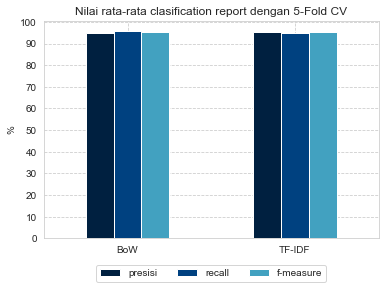

In [46]:
data = [['BoW', data01[0], data01[1], data01[2]],
        ['TF-IDF', data02[0], data02[1], data02[2]]]

dfx = pd.DataFrame(data, columns=['', 'presisi', 'recall', 'f-measure'])
print(dfx)

# plot multikolom dari dataframe
sns.set_palette('ocean',3)
ax = dfx.plot(x='', y=['presisi', 'recall', 'f-measure'], kind='bar')
ax.set_ylabel('%')
ax.set_title('Nilai rata-rata clasification report dengan 5-Fold CV')

ax.yaxis.set_ticks(np.arange(0, 110, 10))
lgd = ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.2), borderaxespad=0., ncol=3)
plt.xticks(rotation=0, ha='center')


## *Catatan: bbox_extra_artists harus berupa iterasi
# plt.savefig('plot5b-SVM_oversampled_kfold_avg_cr_inset.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Comments
- Our original model test accuracy is 94,26% while GridSearch CV score on test-set is 93,13%.
- So, GridSearch CV helps to identify the parameters that will improve the performance for this particular model.
- Here, we should not confuse `best_score_` attribute of `grid_search` with the `score` method on the test-set. 
- The `score` method on the test-set gives the generalization performance of the model. Using the `score` method, we employ a model trained on the whole training set.
- The `best_score_` attribute gives the mean cross-validation accuracy, with cross-validation performed on the training set.

<blockquote>Ref: <i>https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python</i></blockquote>
<blockquote>Ref: <i>Ganganwar, V. (2012) ‘An overview of classification algorithms for imbalanced datasets’, International Journal of Emerging Technology and Advanced Engineering, 2(4), pp. 42–47. Available at: http://www.ijetae.com/files/Volume2Issue4/IJETAE_0412_07.pdf.</i></blockquote>